In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import torch
import pyro
import pyro.distributions as pdist
import pyro.contrib.gp as gp
import math
import numpy as np


def func(X):
    return -torch.sin(6*math.pi*X)**2+6*X**2-5*X**4+3/2

# Data
X = torch.tensor(np.linspace(0, 1, 30))
y = func(X)

# Define Model
kernel = gp.kernels.Periodic(input_dim=1)  # could add a linear kernel
kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0,1))
kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0,1))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))  # the noise level



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
    
# Update the model's data
gpr.set_data(X_train, y_train)

# Use the Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.002)

# Training
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
for i in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()

# Testing
with torch.no_grad():
    mean, variance = gpr(X_test, full_cov=False)
    rmse = torch.sqrt(torch.mean((y_test - mean)**2)).item()
    print(f"Test RMSE: {rmse}")


Test RMSE: 0.17436559798127646


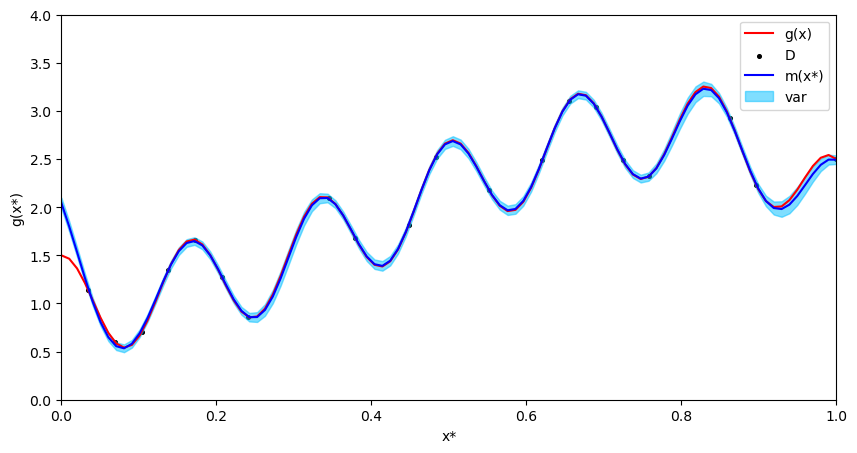

In [2]:
import matplotlib.pyplot as plt

# Generate new X values for plotting
Xnew = torch.linspace(0, 1, 100)

# Get the predictive mean and variance
with torch.no_grad():
    f_loc, f_cov = gpr(Xnew, full_cov=False, noiseless=False)

# Convert to numpy for plotting
Xnew = Xnew.numpy()
f_loc = f_loc.numpy()
f_cov = f_cov.numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(Xnew, func(torch.tensor(Xnew)), label='g(x)', color='red')
plt.xlim(0, 1)
plt.ylim(0, 4)
plt.scatter(X_train.numpy(), y_train.numpy(), label='D', color='black', s=7)
plt.plot(Xnew, f_loc, label='m(x*)', color='blue')
plt.fill_between(Xnew, f_loc+2*np.sqrt(f_cov), f_loc-2*np.sqrt(f_cov), color="deepskyblue", alpha=0.5, label='var')
plt.xlabel("x*")
plt.ylabel("g(x*)")
plt.legend()
plt.show()
